# Machine Learning Diabetes Classification

## Read csv and perform basic data cleaning

In [1]:
# Install zipfile36 if you haven't already
# !pip install zipfile36

In [2]:
# Import our dependencies
import pandas as pd
import numpy as np
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

# SQL
from sqlalchemy import create_engine
import sqlite3 as sql

# Machine learning
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

In [3]:
# Create dataframe
z = urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/00296/dataset_diabetes.zip')
myzip = ZipFile(BytesIO(z.read())).extract('dataset_diabetes/diabetic_data.csv')
df = pd.read_csv(myzip)
df.head(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
# Drop the non-beneficial ID columns, 'encounter_id' and 'patient_nbr'
df = df.drop(['patient_nbr'],1)

# Drop mostly empty columns, 'weight', 'payer_code', 'max_glu_serum', and 'medical_specialty'
df = df.drop(['weight', 'payer_code', 'max_glu_serum', 'medical_specialty', ],1)

# Replace '?' values to nulls
df.replace({'?': np.nan}, inplace=True)

# Replace 'None' values to nulls
df.replace({'None': np.nan}, inplace=True)

# Drop the null rows
df = df.dropna()

/var/folders/xg/sj5cjcj55mdf6d5492q3c5m00000gn/T/ipykernel_79037/4207756282.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop(['patient_nbr'],1)
/var/folders/xg/sj5cjcj55mdf6d5492q3c5m00000gn/T/ipykernel_79037/4207756282.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop(['weight', 'payer_code', 'max_glu_serum', 'medical_specialty', ],1)


In [5]:
# Convert the target column values to normal and high based on their values
x = {'Norm': 'normal'}   
df = df.replace(x)
x = dict.fromkeys(['>7', '>8'], 'high')
df = df.replace(x)
df.reset_index(inplace=True, drop=True)

In [6]:
# Determine the number of unique values in each column.
df.nunique()

encounter_id                16193
race                            5
gender                          2
age                            10
admission_type_id               8
discharge_disposition_id       21
admission_source_id            15
time_in_hospital               14
num_lab_procedures            114
num_procedures                  7
num_medications                67
number_outpatient              24
number_emergency               19
number_inpatient               18
diag_1                        490
diag_2                        486
diag_3                        539
number_diagnoses               12
A1Cresult                       2
metformin                       4
repaglinide                     4
nateglinide                     4
chlorpropamide                  2
glimepiride                     4
acetohexamide                   1
glipizide                       4
glyburide                       4
tolbutamide                     2
pioglitazone                    4
rosiglitazone 

In [7]:
# Drop columns with only 1 value
df = df.drop(['acetohexamide', 'troglitazone', 'examide', 'citoglipton','glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone'],1)

/var/folders/xg/sj5cjcj55mdf6d5492q3c5m00000gn/T/ipykernel_79037/2791377824.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop(['acetohexamide', 'troglitazone', 'examide', 'citoglipton','glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone'],1)


In [8]:
# Drop variables with outliers 
df = df.drop(['number_inpatient', 'number_outpatient','number_emergency'],1)

/var/folders/xg/sj5cjcj55mdf6d5492q3c5m00000gn/T/ipykernel_79037/2491224100.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop(['number_inpatient', 'number_outpatient','number_emergency'],1)


In [9]:
# Look at AGE value counts for binning
age_counts = df.age.value_counts()
age_counts

[70-80)     3437
[60-70)     3437
[50-60)     3269
[80-90)     2169
[40-50)     2110
[30-40)      831
[20-30)      385
[90-100)     310
[10-20)      215
[0-10)        30
Name: age, dtype: int64

In [10]:
# Determine which values to replace if counts are less than ...?
replace_age = list(age_counts[age_counts < 1000].index)

# Replace in dataframe
for app in replace_age:
    df.age = df.age.replace(app,"Other")
    
# Check to make sure binning was successful
df.age.value_counts()

[70-80)    3437
[60-70)    3437
[50-60)    3269
[80-90)    2169
[40-50)    2110
Other      1771
Name: age, dtype: int64

In [11]:
# Keep non-medication variables
df = df[['encounter_id', 'race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures',
         'num_medications', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'A1Cresult', 'change', 'diabetesMed', 'readmitted']]

In [12]:
# Info on the data frame data types, non_null, etc. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16193 entries, 0 to 16192
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   encounter_id              16193 non-null  int64 
 1   race                      16193 non-null  object
 2   gender                    16193 non-null  object
 3   age                       16193 non-null  object
 4   admission_type_id         16193 non-null  int64 
 5   discharge_disposition_id  16193 non-null  int64 
 6   time_in_hospital          16193 non-null  int64 
 7   num_lab_procedures        16193 non-null  int64 
 8   num_procedures            16193 non-null  int64 
 9   num_medications           16193 non-null  int64 
 10  diag_1                    16193 non-null  object
 11  diag_2                    16193 non-null  object
 12  diag_3                    16193 non-null  object
 13  number_diagnoses          16193 non-null  int64 
 14  A1Cresult             

In [13]:
# Looking at dataframe 
df.head()

,encounter_id,race,gender,age,admission_type_id,discharge_disposition_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,diag_1,diag_2,diag_3,number_diagnoses,A1Cresult,change,diabetesMed,readmitted
0,236316,Caucasian,Male,[80-90),1,3,6,64,3,18,427,428,414,7,high,Ch,Yes,NO
1,955884,Caucasian,Female,[70-80),1,3,5,34,0,17,414,411,276,7,high,Ch,Yes,>30
2,1257282,Other,Female,[50-60),1,1,2,53,0,6,590,250.01,401,3,high,Ch,Yes,NO
3,1270524,Caucasian,Male,[60-70),1,2,1,59,0,12,411,401,490,7,normal,No,Yes,NO
4,1455252,Caucasian,Female,[80-90),1,1,3,34,0,11,427,428,414,8,normal,No,No,>30


In [14]:
# Create SQLite engine using SQLAlechmey
engine = create_engine('sqlite:///diabetes_data.db', echo=False)
conn = engine.connect()
df.to_sql('diabetes', conn, index=False, if_exists='replace')

In [15]:
# Check dataset
pd.read_sql('SELECT * FROM diabetes LIMIT 10', conn)

,encounter_id,race,gender,age,admission_type_id,discharge_disposition_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,diag_1,diag_2,diag_3,number_diagnoses,A1Cresult,change,diabetesMed,readmitted
0,236316,Caucasian,Male,[80-90),1,3,6,64,3,18,427,428,414,7,high,Ch,Yes,NO
1,955884,Caucasian,Female,[70-80),1,3,5,34,0,17,414,411,276,7,high,Ch,Yes,>30
2,1257282,Other,Female,[50-60),1,1,2,53,0,6,590,250.01,401,3,high,Ch,Yes,NO
3,1270524,Caucasian,Male,[60-70),1,2,1,59,0,12,411,401,490,7,normal,No,Yes,NO
4,1455252,Caucasian,Female,[80-90),1,1,3,34,0,11,427,428,414,8,normal,No,No,>30
5,1810752,Caucasian,Male,[70-80),1,3,14,78,1,19,434,250.6,250.7,8,normal,Ch,Yes,<30
6,1881372,Caucasian,Male,[60-70),1,2,4,65,2,19,428,410,518,7,normal,No,Yes,<30
7,1968528,Caucasian,Female,[70-80),6,25,10,56,2,24,440,413,250.52,9,high,Ch,Yes,>30
8,2092362,Caucasian,Female,[70-80),6,25,11,88,1,16,250.6,276,581,9,high,Ch,Yes,>30
9,2095932,AfricanAmerican,Female,Other,6,25,8,62,0,21,250.32,403,276,9,high,Ch,Yes,>30


In [16]:
# Create cleanup table
engine.execute('CREATE TABLE "cleaned_columns" ('
               'id BIGINT NOT NULL,'
               'diag_1c VARCHAR, '
               'diag_2c VARCHAR, '
               'diag_3c VARCHAR, '
               'PRIMARY KEY (id));')

In [17]:
# Insert columns into new table to clean
engine.execute('INSERT INTO "cleaned_columns" '
               'SELECT encounter_id AS id, '
               'CASE '
                   'WHEN (diag_1 BETWEEN 390 AND 459) OR (diag_1 = 785) THEN "circulatory" '
                   'WHEN (diag_1 BETWEEN 460 AND 519) OR (diag_1 = 786) THEN "respiratory" '
                   'WHEN (diag_1 BETWEEN 520 AND 579) OR (diag_1 = 787) THEN "digestive" '
                   'WHEN (diag_1 BETWEEN 250 AND 251) THEN "diabetes" '
                   'WHEN (diag_1 BETWEEN 800 AND 999) THEN "injury" '
                   'WHEN (diag_1 BETWEEN 710 AND 739) THEN "musculoskeletal" '
                   'WHEN (diag_1 BETWEEN 580 AND 629) OR (diag_1 = 788) THEN "genitourinary" '
                   'WHEN (diag_1 BETWEEN 140 AND 239) THEN "neoplasms" '
                   'ELSE "other" '
               'END AS diag_1c, '
               'CASE '
                   'WHEN (diag_2 BETWEEN 390 AND 459) OR (diag_2 = 785) THEN "circulatory" '
                   'WHEN (diag_2 BETWEEN 460 AND 519) OR (diag_2 = 786) THEN "respiratory" '
                   'WHEN (diag_2 BETWEEN 520 AND 579) OR (diag_2 = 787) THEN "digestive" '
                   'WHEN (diag_2 BETWEEN 250 AND 251) THEN "diabetes" '
                   'WHEN (diag_2 BETWEEN 800 AND 999) THEN "injury" '
                   'WHEN (diag_2 BETWEEN 710 AND 739) THEN "musculoskeletal" '
                   'WHEN (diag_2 BETWEEN 580 AND 629) OR (diag_2 = 788) THEN "genitourinary" '
                   'WHEN (diag_2 BETWEEN 140 AND 239) THEN "neoplasms" '
                   'ELSE "other" '
               'END AS diag_2c, '
               'CASE '
                   'WHEN (diag_3 BETWEEN 390 AND 459) OR (diag_3 = 785) THEN "circulatory" '
                   'WHEN (diag_3 BETWEEN 460 AND 519) OR (diag_3 = 786) THEN "respiratory" '
                   'WHEN (diag_3 BETWEEN 520 AND 579) OR (diag_3 = 787) THEN "digestive" '
                   'WHEN (diag_3 BETWEEN 250 AND 251) THEN "diabetes" '
                   'WHEN (diag_3 BETWEEN 800 AND 999) THEN "injury" '
                   'WHEN (diag_3 BETWEEN 710 AND 739) THEN "musculoskeletal" '
                   'WHEN (diag_3 BETWEEN 580 AND 629) OR (diag_3 = 788) THEN "genitourinary" '
                   'WHEN (diag_3 BETWEEN 140 AND 239) THEN "neoplasms" '
                   'ELSE "other" '
               'END AS diag_3c '
               'FROM diabetes;')

In [18]:
# Check data
pd.read_sql('SELECT * FROM cleaned_columns LIMIT 10', conn)

,id,diag_1c,diag_2c,diag_3c
0,236316,circulatory,circulatory,circulatory
1,955884,circulatory,circulatory,other
2,1257282,genitourinary,diabetes,circulatory
3,1270524,circulatory,circulatory,respiratory
4,1455252,circulatory,circulatory,circulatory
5,1810752,circulatory,diabetes,diabetes
6,1881372,circulatory,circulatory,respiratory
7,1968528,circulatory,circulatory,diabetes
8,2092362,diabetes,other,genitourinary
9,2095932,diabetes,circulatory,other


In [19]:
# Join diabetes and cleaned_columns tables
diabetes_df = pd.read_sql('SELECT * FROM diabetes JOIN cleaned_columns ON diabetes.encounter_id = cleaned_columns.id', conn)
diabetes_df 

,encounter_id,race,gender,age,admission_type_id,discharge_disposition_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,diag_3,number_diagnoses,A1Cresult,change,diabetesMed,readmitted,id,diag_1c,diag_2c,diag_3c
0,236316,Caucasian,Male,[80-90),1,3,6,64,3,18,...,414,7,high,Ch,Yes,NO,236316,circulatory,circulatory,circulatory
1,955884,Caucasian,Female,[70-80),1,3,5,34,0,17,...,276,7,high,Ch,Yes,>30,955884,circulatory,circulatory,other
2,1257282,Other,Female,[50-60),1,1,2,53,0,6,...,401,3,high,Ch,Yes,NO,1257282,genitourinary,diabetes,circulatory
3,1270524,Caucasian,Male,[60-70),1,2,1,59,0,12,...,490,7,normal,No,Yes,NO,1270524,circulatory,circulatory,respiratory
4,1455252,Caucasian,Female,[80-90),1,1,3,34,0,11,...,414,8,normal,No,No,>30,1455252,circulatory,circulatory,circulatory
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16188,443816024,Caucasian,Female,[70-80),3,6,3,27,1,29,...,250,9,normal,Ch,Yes,NO,443816024,musculoskeletal,circulatory,diabetes
16189,443835140,Caucasian,Male,[70-80),3,6,13,77,6,65,...,486,16,normal,Ch,Yes,NO,443835140,circulatory,circulatory,respiratory
16190,443842016,Caucasian,Female,[70-80),1,1,9,50,2,33,...,250.02,9,high,Ch,Yes,>30,443842016,digestive,digestive,diabetes
16191,443842022,Other,Female,[40-50),1,1,14,73,6,26,...,518,9,high,Ch,Yes,>30,443842022,genitourinary,genitourinary,respiratory


In [20]:
# Check Datatypes
diabetes_df.dtypes

encounter_id                 int64
race                        object
gender                      object
age                         object
admission_type_id            int64
discharge_disposition_id     int64
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
A1Cresult                   object
change                      object
diabetesMed                 object
readmitted                  object
id                           int64
diag_1c                     object
diag_2c                     object
diag_3c                     object
dtype: object

In [21]:
# View DataFrame
diabetes_df

,encounter_id,race,gender,age,admission_type_id,discharge_disposition_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,diag_3,number_diagnoses,A1Cresult,change,diabetesMed,readmitted,id,diag_1c,diag_2c,diag_3c
0,236316,Caucasian,Male,[80-90),1,3,6,64,3,18,...,414,7,high,Ch,Yes,NO,236316,circulatory,circulatory,circulatory
1,955884,Caucasian,Female,[70-80),1,3,5,34,0,17,...,276,7,high,Ch,Yes,>30,955884,circulatory,circulatory,other
2,1257282,Other,Female,[50-60),1,1,2,53,0,6,...,401,3,high,Ch,Yes,NO,1257282,genitourinary,diabetes,circulatory
3,1270524,Caucasian,Male,[60-70),1,2,1,59,0,12,...,490,7,normal,No,Yes,NO,1270524,circulatory,circulatory,respiratory
4,1455252,Caucasian,Female,[80-90),1,1,3,34,0,11,...,414,8,normal,No,No,>30,1455252,circulatory,circulatory,circulatory
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16188,443816024,Caucasian,Female,[70-80),3,6,3,27,1,29,...,250,9,normal,Ch,Yes,NO,443816024,musculoskeletal,circulatory,diabetes
16189,443835140,Caucasian,Male,[70-80),3,6,13,77,6,65,...,486,16,normal,Ch,Yes,NO,443835140,circulatory,circulatory,respiratory
16190,443842016,Caucasian,Female,[70-80),1,1,9,50,2,33,...,250.02,9,high,Ch,Yes,>30,443842016,digestive,digestive,diabetes
16191,443842022,Other,Female,[40-50),1,1,14,73,6,26,...,518,9,high,Ch,Yes,>30,443842022,genitourinary,genitourinary,respiratory


In [22]:
# Drop the non-beneficial ID and diag columns, 'encounter_id', 'id', 'diag_1', 'diag_2', and 'diag_3'
diabetes_2_df = diabetes_df.drop(['encounter_id', 'id', 'diag_1', 'diag_2', 'diag_3'],1)

/var/folders/xg/sj5cjcj55mdf6d5492q3c5m00000gn/T/ipykernel_79037/2165655525.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  diabetes_2_df = diabetes_df.drop(['encounter_id', 'id', 'diag_1', 'diag_2', 'diag_3'],1)


In [23]:
# Generate our categorical variable list
diabetes_2_df_cat = diabetes_2_df.dtypes[diabetes_2_df.dtypes == "object"].index.tolist()
diabetes_2_df_cat

['race',
 'gender',
 'age',
 'A1Cresult',
 'change',
 'diabetesMed',
 'readmitted',
 'diag_1c',
 'diag_2c',
 'diag_3c']

In [24]:
# OneHot encode the categorical data
from sklearn.preprocessing import OneHotEncoder

# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(diabetes_2_df[diabetes_2_df_cat]))

# Add the encoded variable names to the DataFrame
encode_df.columns = enc.get_feature_names_out(diabetes_2_df_cat)
encode_df

,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,age_Other,age_[40-50),age_[50-60),...,diag_2c_respiratory,diag_3c_circulatory,diag_3c_diabetes,diag_3c_digestive,diag_3c_genitourinary,diag_3c_injury,diag_3c_musculoskeletal,diag_3c_neoplasms,diag_3c_other,diag_3c_respiratory
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16188,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16189,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
16190,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16191,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [25]:
# Merge one-hot encoded features and drop the originals
diabetes_2_df = diabetes_2_df.merge(encode_df,left_index=True, right_index=True)
diabetes_2_df = diabetes_2_df.drop(diabetes_2_df_cat,1)
diabetes_2_df = diabetes_2_df.drop('A1Cresult_normal',1)
diabetes_2_df.dtypes

/var/folders/xg/sj5cjcj55mdf6d5492q3c5m00000gn/T/ipykernel_79037/3091633488.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  diabetes_2_df = diabetes_2_df.drop(diabetes_2_df_cat,1)
/var/folders/xg/sj5cjcj55mdf6d5492q3c5m00000gn/T/ipykernel_79037/3091633488.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  diabetes_2_df = diabetes_2_df.drop('A1Cresult_normal',1)


admission_type_id             int64
discharge_disposition_id      int64
time_in_hospital              int64
num_lab_procedures            int64
num_procedures                int64
num_medications               int64
number_diagnoses              int64
race_AfricanAmerican        float64
race_Asian                  float64
race_Caucasian              float64
race_Hispanic               float64
race_Other                  float64
gender_Female               float64
gender_Male                 float64
age_Other                   float64
age_[40-50)                 float64
age_[50-60)                 float64
age_[60-70)                 float64
age_[70-80)                 float64
age_[80-90)                 float64
A1Cresult_high              float64
change_Ch                   float64
change_No                   float64
diabetesMed_No              float64
diabetesMed_Yes             float64
readmitted_<30              float64
readmitted_>30              float64
readmitted_NO               

In [26]:
# Remove target from features data
y = diabetes_2_df['A1Cresult_high']
X =  diabetes_2_df.drop(['A1Cresult_high'],1)

# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

/var/folders/xg/sj5cjcj55mdf6d5492q3c5m00000gn/T/ipykernel_79037/1751792563.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X =  diabetes_2_df.drop(['A1Cresult_high'],1)


In [27]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=128, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
print(f" Random forest predictive accuracy: {accuracy_score(y_test,y_pred):.3f}")

 Random forest predictive accuracy: 0.703


In [28]:
importances = rf_model.feature_importances_
importances
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.1205149485800812, 'num_lab_procedures'),
 (0.10804975398443811, 'num_medications'),
 (0.08322901860052423, 'time_in_hospital'),
 (0.05122674770783607, 'num_procedures'),
 (0.0480687645967012, 'number_diagnoses'),
 (0.045828075148054113, 'discharge_disposition_id'),
 (0.042324131698914996, 'admission_type_id'),
 (0.01864971500191225, 'diag_3c_circulatory'),
 (0.018595868022349363, 'diag_3c_other'),
 (0.01814222823947541, 'diag_2c_circulatory'),
 (0.017983524668156253, 'gender_Female'),
 (0.01733496805358837, 'gender_Male'),
 (0.016986457625554088, 'readmitted_NO'),
 (0.016620973490749882, 'diag_2c_other'),
 (0.01635687954974955, 'diag_1c_circulatory'),
 (0.01564902555399864, 'readmitted_>30'),
 (0.015421170057743823, 'age_[70-80)'),
 (0.01535849792897164, 'age_[50-60)'),
 (0.01510401727716693, 'race_Caucasian'),
 (0.014939347242208353, 'age_[60-70)'),
 (0.014441607304863407, 'diag_1c_other'),
 (0.014343710565264515, 'race_AfricanAmerican'),
 (0.013797742521398402, 'diag_1c_respirato

In [29]:
# Define the model - deep neural net
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = len(X_train_scaled[0])*3
hidden_nodes_layer2 = len(X_train_scaled[0])*2
hidden_nodes_layer3 = len(X_train_scaled[0])

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 162)               8910      
                                                                 
 dense_1 (Dense)             (None, 108)               17604     
                                                                 
 dense_2 (Dense)             (None, 108)               11772     
                                                                 
 dense_3 (Dense)             (None, 1)                 109       
                                                                 
Total params: 38,395
Trainable params: 38,395
Non-trainable params: 0
_________________________________________________________________


2022-02-22 20:39:59.585932: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [30]:
# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

In [31]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Create a callback that saves the model's weights every epoch
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=5)

In [32]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=50) 

Epoch 1/50
380/380 [==============================] - 4s 7ms/step - loss: 0.5906 - accuracy: 0.6993
Epoch 2/50
380/380 [==============================] - 2s 7ms/step - loss: 0.5673 - accuracy: 0.7134
Epoch 3/50
380/380 [==============================] - 2s 7ms/step - loss: 0.5549 - accuracy: 0.7203
Epoch 4/50
380/380 [==============================] - 2s 7ms/step - loss: 0.5421 - accuracy: 0.7288
Epoch 5/50
380/380 [==============================] - 2s 6ms/step - loss: 0.5265 - accuracy: 0.7404
Epoch 6/50
380/380 [==============================] - 2s 6ms/step - loss: 0.5084 - accuracy: 0.7530
Epoch 7/50
380/380 [==============================] - 3s 8ms/step - loss: 0.4866 - accuracy: 0.7705
Epoch 8/50
380/380 [==============================] - 2s 6ms/step - loss: 0.4631 - accuracy: 0.7794
Epoch 9/50
380/380 [==============================] - 3s 7ms/step - loss: 0.4387 - accuracy: 0.7925
Epoch 10/50
380/380 [==============================] - 3s 7ms/step - loss: 0.4087 - accuracy: 0.8126

In [33]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

127/127 - 1s - loss: 2.6479 - accuracy: 0.6453 - 1s/epoch - 8ms/step
Loss: 2.6479392051696777, Accuracy: 0.6453445553779602


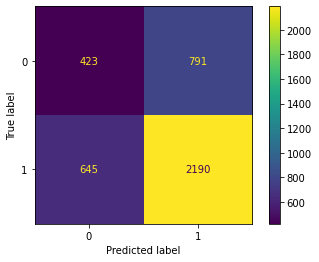

In [34]:
# Create the confusion matrix
predictions = nn.predict(X_test_scaled)
predictions = np.round(predictions).astype(int)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [35]:
# Export our model to HDF5 file
nn.save("ML_Diabetes.h5")